# Debugging Bandit Algorithms

## Monte Carlo Simulations Are Like Unit Tests for Bandit Algorithms

Bandit algorithms exemplify two types of learning that are not present in standard ML examples: _active learning_, which refers to algorithms that actively select which data they should receive; and _online learning_, which refers to algorithms that analyse data in real-time and provide results on the fly.

This means that there is a complicated feedback cycle in every bandit algorithm: as shown in Figure below, the behavior of the algorithm depends on the data it sees, but the data the algorithm sees depends on the behavior of the algorithm. Debugging a bandit algorithm is therefore substantially more complicated than debugging a straight ma‐ chine learning algorithm that isn’t doing active learning. You can’t just feed a bandit algorithm data: you have to turn it loose somewhere to see how it might behave in production. Of course, doing this on your own site could be very risky: you don’t want to unleash untested code on a live site.

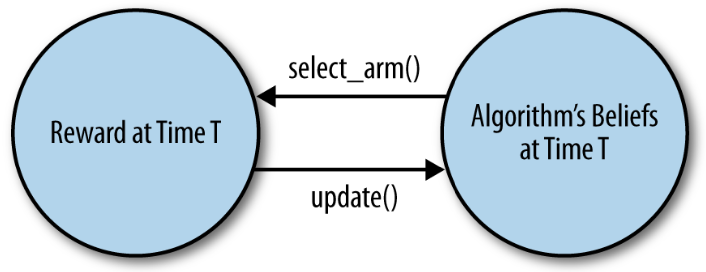

_Bandit data and bandit analysis are inseparable_

In order to solve both of these problems, we’re going to use an alternative to standard unit-testing that’s appropriate for testing bandit algorithms. This alternative is called Monte Carlo simulations. The name comes from World War II, when scientists tested how weaponry and other systems might behave by using simple computers equipped with a random number generator.

For our purposes, a Monte Carlo simulation will let our implementation of a bandit algorithm actively make decisions about which data it will receive, because our simulations will be able to provide simulated data in real-time to the algorithm for analysis. In short, we’re going to deal with the feedback cycle shown earlier by coding up both our bandit algorithm and a simulation of the bandit’s arms that the algorithm has to select between. The two pieces of code then work together to generate an example of how the algorithm might really function in production.

Because each simulation is powered by random numbers, the results are noisy. For that reason, you’ll want to run lots of simulations. We can easily simulate 100,000’s of runs of a bandit algorithm to develop an intuition for its behavior in different settings. This is arguably far more important than understanding any specific bandit algorithm.

## Simulating the Arms of a Bandit Problem

In order to reasonably simulate what might happen if you were to deploy an epsilon-Greedy algorithm in production, we need to set up some hypothetical arms. This hypothetical arm will let us simulate settings like:

- _Optimizing click-through rates for ads_: Every time we show someone an ad, we’ll imagine that there’s a fixed probability that they’ll click on the ad. The bandit algorithm will then estimate this probability and try to decide on a strategy for showing ads that maximises the click-through rate. 
- _Conversion rates for new users_: Every time a new visitor comes to our site who isn’t already a registered user, we’ll imagine that there’s a fixed probability that they’ll register as a user after seeing the landing page. We’ll then estimate this probability and try to decide on a strategy for maximizing our conversion rate.

Our simulated arm is going to be called a Bernoulli arm. Calling this type of an arm a Bernoulli arm is just a jargony way of saying that we’re dealing with an arm that rewards you with a value of 1 some percentage of the time and rewards you with a value of 0 the rest of the time. This 0/1 framework is a very simple way to simulate situations like click- throughs or user signups: the potential user arrives at your site; you select an arm for them in which you, for example, show them one specific color logo; finally, they either do sign up for the site (and give you reward 1) or they don’t (and give you reward 0). If 2% of people who see a red logo sign up and 5% of people who see a green logo sign up, then you can abstract away the details and talk about two arms: one arm outputs 1 unit of reward 2% of the time, the other arm outputs 1 unit of reward 5% of the time

In [8]:
import random

class BernoulliArm():

    def __init__(self, p):
        self.p = p
        
    def __repr__(self):
        return f'<BernoulliArm p={self.p}>'

    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

First, there’s a class called BernoulliArm that has a single field, `p`, which tells us the probability of getting a reward of 1 from that arm. Second, there’s a method, draw, that, when called, produces 1 unit of reward with probability `p`. That’s the entirety of our abstract way of thinking about click-throughs and so on. Amazingly enough, this provides enough material for a very powerful simulation framework.

The only big thing that’s missing from this approach is that we typically have to work with many arms, so we’ll need to set up an array of Arm objects. For example, we could do the following:

In [9]:
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

In [10]:
arms

[<BernoulliArm p=0.1>,
 <BernoulliArm p=0.1>,
 <BernoulliArm p=0.1>,
 <BernoulliArm p=0.9>,
 <BernoulliArm p=0.1>]

This will set up an array that contains 5 arms. 4 of them output reward 10% of the time, while the best of them outputs a reward 90% of the time. This is a very black-and-white situation that you won’t see in the real world, but that means that it’s a nice starting point for testing our algorithms.

To try out our Bernoulli arms, you might calldrawa few times on some of the elements of our array as follows:

In [14]:
print(arms[0], arms[0].draw())
print(arms[1], arms[1].draw())
print(arms[2], arms[2].draw())
print(arms[2], arms[2].draw())
print(arms[3], arms[3].draw())
print(arms[2], arms[2].draw())
print(arms[4], arms[4].draw())

<BernoulliArm p=0.1> 0.0
<BernoulliArm p=0.1> 0.0
<BernoulliArm p=0.1> 0.0
<BernoulliArm p=0.1> 0.0
<BernoulliArm p=0.9> 1.0
<BernoulliArm p=0.1> 0.0
<BernoulliArm p=0.1> 0.0


That should give you some sense of how this setup works. Our Multiarmed Bandit problem gets represented as an array of arm objects, each of which implements a draw method that simulates playing that specific arm.

With that in place, we’re almost ready to start experimenting with the epsilon-Greedy algorithm. But before we do that, we’re going to set up a very generic framework for testing an algorithm. This framework is described entirely by the `test_algorithm` function shown below and will be the only testing tool needed:

In [32]:
(0 - 1) * 250 + 0 - 1

-251

In [49]:
def test_algorithm(algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]

    for sim in range(num_sims):
        sim = sim + 1
        algo.initialise(len(arms))

        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1
            print(sim, t, index)
        
            sim_nums[index] = sim
            times[index] = t

            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm

            reward = arms[chosen_arms[index]].draw()
            rewards[index] = reward

            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward
            algo.update(chosen_arm, reward)

    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

How does this work?

We pass in a few objects:
- A bandit algorithm that we want to test.
- An array of arms we want to simulate draws from.
- A fixed number of simultations to run to average over the noise in each simulation.
- The number of times each algorithm is allowed to pull on arms during each simulation. Any algorithm that’s not terrible will eventually learn which arm is best; the interesting thing to study in a simulation is whether an algorithm does well when it only has 100 (or 100,000) tries to find the best arm.

The framework then uses these objects to run many independent simulations. For each of these, it:

- Initializes the bandit algorithm’s settings from scratch so that it has no prior knowledge about which arm is best.
- Loops over opportunities to pull an arm. On each step of this loop, it:
    - Calls select_arm to see which arm the algorithm chooses.
    - Calls draw on that arm to simulate the result of pulling that arm.
    - Records the amount of reward received by the algorithm and then calls update to let the algorithm process that new piece of information.
    
Finally, the testing framework returns a data set that tells us for each simulation which arm was chosen and how well the algorithm did at each point in time.

To show you how to use this testing framework, we need to pass in a specific algorithm and a specific set of arms. In the code below, we show you what happens when applying the epsilon-Greedy algorithm we implemented earlier against the five Bernoulli arms we defined just a moment ago. For simplicity, we’ve reproduced all of the necessary code below, including redefining the five Bernoulli arms:

In [23]:
"""
Code from notebook 3
"""
def ind_max(x):
    m = max(x)
    return x.index(m) 

def select_arm(self):
    if random.random() > self.epsilon:
        return ind_max(self.values) 
    else:
        return random.randrange(len(self.values))

class EpsilonGreedy:
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        
    def initialise(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        
    def ind_max(self, x):
        m = max(x)
        return x.index(m) 

    def select_arm(self):
        if random.random() > self.epsilon:
            return self.ind_max(self.values) 
        else:
            return random.randrange(len(self.values))
        
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

In [73]:
import random
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(ind_max(means))) # fix this

# Lower epsilon will select the best model e.g. if random number is greater than epsilon = 0.1 pick best arm
# for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
for epsilon in [0.9]:
    algo = EpsilonGreedy(epsilon, [], [])
    algo.initialise(n_arms)
    results = test_algorithm(algo, arms, 2, 5)

Best arm is 2
1 1 0
1 2 1
1 3 2
1 4 3
1 5 4
2 1 5
2 2 6
2 3 7
2 4 8
2 5 9


In [74]:
len(results)

5

In [75]:
# sim num
results[0]

[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]

In [76]:
# times
results[1]

[1, 2, 3, 4, 5, 1, 2, 3, 4, 5]

In [77]:
# chosen_arms
results[2]

[3, 1, 3, 0, 1, 2, 4, 1, 4, 3]

In [78]:
# rewards
results[3]

[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]

In [81]:
# cumulative_rewards
# This looks at the global level. Look at previous reward and add the current award
results[4]

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0]

In [82]:
for i in zip(results[0], results[1], results[2], results[3], results[4]):
    print(i)

(1, 1, 3, 0.0, 0.0)
(1, 2, 1, 1.0, 1.0)
(1, 3, 3, 0.0, 1.0)
(1, 4, 0, 0.0, 1.0)
(1, 5, 1, 0.0, 1.0)
(2, 1, 2, 1.0, 1.0)
(2, 2, 4, 1.0, 2.0)
(2, 3, 1, 0.0, 2.0)
(2, 4, 4, 0.0, 2.0)
(2, 5, 3, 0.0, 2.0)
